In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time
import matplotlib.pyplot as plt #from keras.datasets import fashion_mnist
from IPython.display import display 
from PIL import Image
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten #from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input

import os

Using TensorFlow backend.


In [2]:
! ls

Fashion-MNIST VGG16.ipynb fasion_mnist_data         karas_models


# Prepare Fashion-MNIST Dataset

In [30]:
train_data = pd.read_csv('fasion_mnist_data/fashion-mnist_train.zip')
test_data = pd.read_csv('fasion_mnist_data/fashion-mnist_test.zip')

In [31]:
train_data.shape #(60,000*785)
test_data.shape #(10000,785)
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) # (60000,)
test_Y = np.array(test_data.iloc[:,0]) #(10000,)


# Alternative
# from keras.datasets import fashion_mnist
# ((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [32]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [34]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [35]:
# Convert the images into 3 channels
train_X = np.dstack([train_X] * 3)
test_X = np.dstack([test_X] * 3)

train_X.shape, test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [36]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28, 28, 3)
test_X = test_X.reshape(-1, 28, 28, 3)

train_X.shape, test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [37]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])

#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [38]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [39]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [40]:
# Splitting train data as train and validation data
train_X, valid_X, train_label, valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=27
                                                           )

In [41]:
# Check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [42]:
# Define the parameters for instantiating VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [43]:
# Preprocessing the input 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input(test_X)

In [44]:
! ls

Fashion-MNIST - Classification.ipynb karas_models
fasion_mnist_data


# VGG 16 Model

#### Create base model of VGG16

In [45]:
conv_base = VGG16(weights='karas_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

### Transfer Learning

In [46]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

#for layer in conv_base.layers:
#    layer.trainable = False

12000/12000 [==============================] - 161s 13ms/step


In [50]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [49]:
# Current shape of features
print(train_features.shape, "\n", test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [52]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

#### Add dense layers to output features of VGG16

In [54]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [55]:
# Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [56]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

#### Model Training

In [57]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/anaconda3/envs/datax/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [58]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 114us/step - loss: 1.4610 - acc: 0.4613 - val_loss: 1.1438 - val_acc: 0.5887
Epoch 2/100
48000/48000 [==============================] - 5s 101us/step - loss: 1.0914 - acc: 0.6003 - val_loss: 0.9896 - val_acc: 0.6428
Epoch 3/100
48000/48000 [==============================] - 5s 99us/step - loss: 0.9916 - acc: 0.6352 - val_loss: 0.9700 - val_acc: 0.6548
Epoch 4/100
48000/48000 [==============================] - 5s 98us/step - loss: 0.9357 - acc: 0.6567 - val_loss: 0.9030 - val_acc: 0.6613
Epoch 5/100
48000/48000 [==============================] - 5s 97us/step - loss: 0.9142 - acc: 0.6630 - val_loss: 0.8674 - val_acc: 0.6818
Epoch 6/100
48000/48000 [==============================] - 5s 95us/step - loss: 0.8877 - acc: 0.6715 - val_loss: 0.8792 - val_acc: 0.6876
Epoch 7/100
48000/48000 [==============================] - 5s 101us/step

#### Model Validation

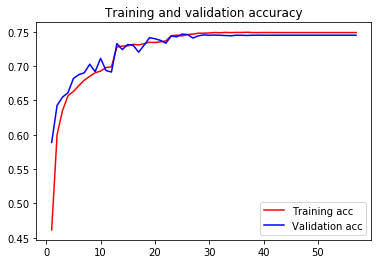

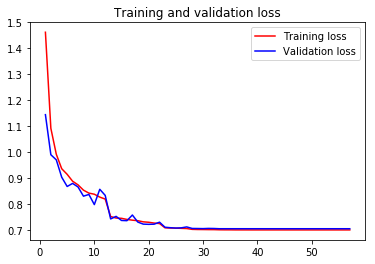

In [59]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# MiniVGGNet

In [8]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
 
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
    
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
    
        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
    
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
    
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
    
        # return the constructed network architecture
        return model

In [4]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras import backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
 
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32

In [5]:
# grab the Fashion MNIST dataset (if this is your first time running
# this the dataset will be automatically downloaded)
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
 
# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
    testX = testX.reshape((testX.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))

[INFO] loading Fashion MNIST...
4423680/4422102 [==============================] - 2s 0us/step


In [6]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
 
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)
 
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [10]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
 
# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=BS, epochs=NUM_EPOCHS)

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] training model...
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 333s 6ms/step - loss: 0.5525 - acc: 0.8139 - val_loss: 0.3217 - val_acc: 0.8853
Epoch 2/25
60000/60000 [==============================] - 333s 6ms/step - loss: 0.3479 - acc: 0.8757 - val_loss: 0.2817 - val_acc: 0.8969
Epoch 3/25
60000/60000 [==============================] - 335s 6ms/step - loss: 0.2979 - acc: 0.8927 - val_loss: 0.2509 - val_acc: 0.9070
Epoch 4/25
60000/60000 [==============================] - 336s 6ms/step - loss: 0.2731 - acc: 0.9022 - val_loss: 0.2390 - val_acc: 0.9103
Epoch 5/25
60000/60000 [==============================] - 332s 6ms/step - loss: 0.2572 - acc: 0.9064 - val_loss:

In [11]:
# make predictions on the test set
preds = model.predict(testX)
 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1), target_names=labelNames))
 
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.90      0.87      0.88      1000
     trouser       0.99      0.99      0.99      1000
    pullover       0.90      0.91      0.90      1000
       dress       0.93      0.94      0.93      1000
        coat       0.88      0.91      0.89      1000
      sandal       0.99      0.98      0.99      1000
       shirt       0.80      0.78      0.79      1000
     sneaker       0.96      0.98      0.97      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.96      0.97      1000

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

